# INPUTS

In [1]:
# Especifique o tamanho da janela de treino:
T = 3

# Num total de neurônios: múltiplo de 6
#num_tot_neuronios = 6*8 # = 48
num_tot_neuronios = 6*10 # = 96


colunas_input = ['Biomass (mg/L)', 'Nitrate (mg/L)', 'Phycocyanin (mg/L)']
colunas_output = ['Phycocyanin (mg/L)']

# batches_utilizados = [0, 1, 2, 3]
# batches_train = [0, 1, 2]
# batches_test = [3]

batches_utilizados = [0, 1, 2, 3]
batches_train = [1, 2, 3]
batches_test = [0]

# -------------------------------------------------------------------------------------------------------------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Dense, RNN, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops import math_ops
from tensorflow.random import set_seed

import tensorflow_addons as tfa
from tensorflow_addons.rnn import ESNCell

import time
import datetime

In [4]:
df = pd.read_csv('../FicoC/0_fitted data.csv')

In [5]:
df

,60 day run,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,60 day fitted,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 29,60%,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,60% fitted,Unnamed: 36,Unnamed: 37,Unnamed: 38
0,time,biomass,nitrate,pc,NaN,time,biomass,nitrate,pc,NaN,...,NaN,time,biomass,nitrate,pc,NaN,time,biomass,nitrate,pc
1,0,240.5309695,NaN,4.324239941,NaN,0,149.98,1210.7,0,NaN,...,NaN,1,142.62777,670.729927,2.152641879,NaN,0,72.884,708.39,0
2,0.9173611111,271.4472785,1096.597856,4.779299848,NaN,1,223.6554,1171.4407,8.7803,NaN,...,NaN,2,205.41987,675.6569343,5.18590998,NaN,1,138.9746,699.8761,2.4396
3,1.883333333,318.7523723,1160.423633,13.33333333,NaN,2,298.428,1132.6208,17.3638,NaN,...,NaN,3,289.74069,667.4452555,7.43295499,NaN,2,203.4264,689.3162,4.85
4,4.830555556,464.9254025,1002.654289,22.49619482,NaN,3,374.2174,1094.2403,25.7505,NaN,...,NaN,4,307.68129,708.1751825,9.68,NaN,3,266.2394,676.7103,7.2312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,NaN,NaN,NaN,NaN,NaN,51,3632.0254,0,196.8753,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,NaN,NaN,52,3659.148,0,195.6188,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,NaN,NaN,NaN,NaN,NaN,53,3683.2674,0,194.1655,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,54,3704.3032,0,192.5154,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Separa as bateladas do arquivo
dict_colunas = {
                'time':'Time (days)',
                'biomass':'Biomass (mg/L)',
                'nitrate':'Nitrate (mg/L)',
                'pc':'Phycocyanin (mg/L)',
                }
batches_list = []
j = 0
# for i in range(0, 4):
#     nome = 'batch_'+ str(i) + '_' + str(df.columns[5+10*j]).replace(" ", "_").replace("%", "percent")
#     globals()[nome] = df[df.columns[(5+10*j):(9+10*j)]]
#     globals()[nome].columns = globals()[nome].iloc[0]
#     globals()[nome] = globals()[nome][1:].rename(columns=dict_colunas).reset_index(drop=True).dropna(how='all')
#     batches_list.append(globals()[nome])
#     j += 1

for i in range(0, 4):
    nome = 'batch_'+ str(i)
    globals()[nome] = df[df.columns[(5+10*j):(9+10*j)]]
    globals()[nome].columns = globals()[nome].iloc[0]
    globals()[nome] = globals()[nome][1:].rename(columns=dict_colunas).reset_index(drop=True).dropna(how='all')
    batches_list.append(globals()[nome])
    j += 1

In [7]:
# Corta o Batch 0 para que tenha o mesmo comprimento que os outros
batches_list[0] = batches_list[0].loc[:17]

In [8]:
# Treino e teste:

batches_train_dados = list( batches_list[i] for i in batches_train )
batches_test_dados = list( batches_list[i] for i in batches_test )

#batches_train_dados = batches_list[1:]
#batches_test_dados = batches_list[0:]

In [9]:
# scaling - Só utilizar treino.
df_batches = pd.DataFrame()
scaler = StandardScaler()
for batch in batches_train_dados:
    df_batches = pd.concat([df_batches, batch], ignore_index = True)
scaler = scaler.fit(df_batches)
del df_batches

batches_list_scaled = []
for batch in batches_list:
    batches_list_scaled.append(pd.DataFrame( scaler.transform(batch), columns = batches_list[0].columns))
    
batches_train_scaled = batches_list_scaled[1:]
batches_test_scaled = [batches_list_scaled[0]]

# batches_list_scaled = batches_list
# batches_train_scaled = batches_list[1:]
# batches_test_scaled = [batches_list[0]]

for i in range(len(batches_train_scaled)):
    batches_train_scaled[i] = batches_train_scaled[i].drop('Time (days)', axis=1)
for i in range(len(batches_test_scaled)):
    batches_test_scaled[i] = batches_test_scaled[i].drop('Time (days)', axis=1)

In [10]:
# X e Y

# Especifique o tamanho da janela de treino:
# T = 20

# colunas_input = ['Biomass (mg/L)', 'Nitrate (mg/L)']
# colunas_output = ['Phycocyanin (mg/L)']

# -----------------------------------------------------------------------------------------------------------------------------#
# Criando os objetos X (input) e Y (output) para o treino:

X_treino = []
Y_treino = []

qntd_features_input = len(colunas_input)
len_batches_train = len(batches_train_scaled[0])

for i in batches_train:
    
    globals()['X_batch_'+str(i)] = batches_list_scaled[i][colunas_input].values

    
    globals()['Y_batch_'+str(i)] = batches_list_scaled[i][colunas_output].values
    

    for t in range(len_batches_train-T):
        x = globals()['X_batch_'+str(i)][t:t+T]
        X_treino.append(x)

        y =  globals()['Y_batch_'+str(i)][t+T]
        Y_treino.append(y)

# Observe que X é uma 'tabelona' com TODAS as janelas de TODOS os batches, e Y é o output de cada uma destas janelas.
np.array(X_treino)
X_treino = np.array(X_treino).reshape(-1,T,qntd_features_input)
Y_treino = np.array(Y_treino).reshape(-1,1)

# -----------------------------------------------------------------------------------------------------------------------------#
# Criando os objetos X (input) e Y (output) para o teste:

X_teste = []
Y_teste = []
len_batches_test =len(batches_test_scaled[0])

for i in batches_test:
    
    globals()['X_batch_'+str(i)] = batches_list_scaled[i][colunas_input].values

    
    globals()['Y_batch_'+str(i)] = batches_list_scaled[i][colunas_output].values
    

    for t in range(len_batches_test-T):
        x = globals()['X_batch_'+str(i)][t:t+T]
        X_teste.append(x)

        y =  globals()['Y_batch_'+str(i)][t+T]
        Y_teste.append(y)

X_teste = np.array(X_teste).reshape(-1,T,qntd_features_input)
Y_teste = np.array(Y_teste).reshape(-1,1)       

In [11]:
def Modelo_generalizado(primeira_camada, segunda_camada, terceira_camada, numero_neuronios, T, qntd_features_input):
        
    tf.keras.backend.clear_session()
    
    i = Input(shape = (T,qntd_features_input))
    
    numero_camadas = 1
    proporções = [] 
    
    if(primeira_camada == '0'):
    
        return('Erro: primeira camada inexistente')
    
    if(terceira_camada == '0'):
    
        if(segunda_camada == '0'):
    
            numero_camadas = 1
    
        else :
            numero_camadas = 2
    else: 
        numero_camadas = 3
    
    #--------------------------------------------------------------------------------------------------
    #Caso tenhamos tres camadas    
    
    if(numero_camadas == 3):
        proporcoes = [3, 2, 1]
        
        #Definindo a primeira camada
        if(primeira_camada == 'D'):
        
            x = Dense(numero_neuronios*proporcoes[0]//sum(proporcoes))(i)
    
        elif(primeira_camada == 'S'): 
            
            x = SimpleRNN(numero_neuronios*proporcoes[0]//sum(proporcoes), return_sequences = True)(i)

        elif(primeira_camada == 'L'): 
            
            x = LSTM(numero_neuronios*proporcoes[0]//sum(proporcoes), return_sequences = True)(i)
     
        elif(primeira_camada == 'G'): 
            
            x = GRU(numero_neuronios*proporcoes[0]//sum(proporcoes), return_sequences = True)(i)
    
        elif(primeira_camada == 'E'): 
            
            x = RNN(ESNCell(numero_neuronios*proporcoes[0]//sum(proporcoes)), return_sequences = True)(i)
        
        
        #Definindo a segunda camada
        
        if(segunda_camada == 'D'):
        
            x = Dense(numero_neuronios*proporcoes[1]//sum(proporcoes))(x)
        
        elif(segunda_camada == 'S'): 
        
            x = SimpleRNN(numero_neuronios*proporcoes[1]//sum(proporcoes), return_sequences = True)(x)
        
        elif(segunda_camada == 'L'): 
            
            x = LSTM(numero_neuronios*proporcoes[1]//sum(proporcoes), return_sequences = True)(x)
        
        elif(segunda_camada == 'G'): 
            
            x = GRU(numero_neuronios*proporcoes[1]//sum(proporcoes), return_sequences = True)(x)
    
        elif(segunda_camada == 'E'): 
            
            x = RNN(ESNCell(numero_neuronios*proporcoes[1]//sum(proporcoes)), return_sequences = True)(x)
    
    
        #Definindo a terceira camada
        if(terceira_camada == 'D'):
            
            x = Dense(numero_neuronios*proporcoes[2]//sum(proporcoes))(x)
    
        elif(terceira_camada == 'S'): 
            
            x = SimpleRNN(numero_neuronios*proporcoes[2]//sum(proporcoes))(x)

        elif(terceira_camada == 'L'): 
            
            x = LSTM(numero_neuronios*proporcoes[2]//sum(proporcoes))(x)
     
        elif(terceira_camada == 'G'): 
            
            x = GRU(numero_neuronios*proporcoes[2]//sum(proporcoes))(x)
    
        elif(terceira_camada == 'E'): 
            
            x = RNN(ESNCell(numero_neuronios*proporcoes[2]//sum(proporcoes)))(x)
    
    
    #--------------------------------------------------------------------------------------------------
    elif(numero_camadas == 2):
        proporcoes = [2, 1]
        
        if(primeira_camada == 'D'):
            
            x = Dense(numero_neuronios*proporcoes[0]//sum(proporcoes))(i)
    
        elif(primeira_camada == 'S'): 
            
            x = SimpleRNN(numero_neuronios*proporcoes[0]//sum(proporcoes), return_sequences = True)(i)

        elif(primeira_camada == 'L'): 
            
            x = LSTM(numero_neuronios*proporcoes[0]//sum(proporcoes), return_sequences = True)(i)
     
        elif(primeira_camada == 'G'): 
            
            x = GRU(numero_neuronios*proporcoes[0]//sum(proporcoes), return_sequences = True)(i)
    
        elif(primeira_camada == 'E'): 
            
            x = RNN(ESNCell(numero_neuronios*proporcoes[0]//sum(proporcoes)), return_sequences = True)(i)
        
        #Definindo a segunda camada
        if(segunda_camada == 'D'):
            
            x = Dense(numero_neuronios*proporcoes[1]//sum(proporcoes))(x)
    
        elif(segunda_camada == 'S'): 
            
            x = SimpleRNN(numero_neuronios*proporcoes[1]//sum(proporcoes))(x)

        elif(segunda_camada == 'L'): 
            
            x = LSTM(numero_neuronios*proporcoes[1]//sum(proporcoes))(x)
     
        elif(segunda_camada == 'G'): 
            
            x = GRU(numero_neuronios*proporcoes[1]//sum(proporcoes))(x)
    
        elif(segunda_camada == 'E'): 
            
            x = RNN(ESNCell(numero_neuronios*proporcoes[1]//sum(proporcoes)))(x)
    
    
    #--------------------------------------------------------------------------------------------------
    if(numero_camadas == 1):
        proporcoes = [1]
    
        if(primeira_camada == 'D'):
            
            x = Dense(numero_neuronios*proporcoes[0]//sum(proporcoes))(i)
    
        elif(primeira_camada == 'S'): 
            
            x = SimpleRNN(numero_neuronios*proporcoes[0]//sum(proporcoes))(i)

        elif(primeira_camada == 'L'): 
            
            x = LSTM(numero_neuronios*proporcoes[0]//sum(proporcoes))(i)
     
        elif(primeira_camada == 'G'): 
            
            x = GRU(numero_neuronios*proporcoes[0]//sum(proporcoes))(i)
    
        elif(primeira_camada == 'E'): 
            
            x = RNN(ESNCell(numero_neuronios*proporcoes[0]//sum(proporcoes)))(i)
    
    
    #--------------------------------------------------------------------------------------------------
    x = Dense(1)(x)
    
    model = Model(i,x)
    
    model.compile(loss = 'mse', optimizer = Adam(learning_rate = 0.01))

    return(model)

In [12]:
def Treinadora_modelo(model, X_treino, Y_treino, X_teste, Y_teste):
    
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50, restore_best_weights=True)
    r = model.fit(X_treino, Y_treino, epochs = 100, validation_data=(X_teste, Y_teste), callbacks=[early_stop], verbose=0)
    
    return(r)

In [13]:
def Predicao_modelo(inputs_batch, outputs_batch, model):
    
    start_time = time.time()

    validation_target  = [0]*len(batches_test)

    final_predictions = []
    
    for k in range(len(batches_test)):

        validation_predictions = []
        validation_target[k] = outputs_batch[k]

        # first validation input    
        i = 0 
        last_x = inputs_batch[k][0]
        
        while len(validation_predictions) < len(validation_target[k])-1:
            p = model.predict(last_x.reshape(1, -1, qntd_features_input))[0,0] # O last_x é um array de ordem 2. Por isso, precisamos fazer o reshape para que seja de ordem 3

            # update the predictions list
            validation_predictions.append(p)

            # make the new input
            # fazer só para a penicilina 

            last_x = np.roll(last_x, -1, axis = 0)

            i += 1
            
            last_x[-1][0] = inputs_batch[k][i][-1][0] # 'Biomass (mg/L)'?
            last_x[-1][1] = inputs_batch[k][i][-1][1] # 'Nitrate (mg/L)'?
            last_x[-1][2] = p                         # 'Phycocyanin (mg/L)'


        final_predictions.append(validation_predictions)

        print('%d%%' %(100*((k+1)/len(batches_test))), sep=' ', end='\r')

    print("\n--- %s seconds ---" % (time.time() - start_time))
    
    return(final_predictions, validation_target)


In [14]:
def Avaliacao_modelos(batches_test, validation_target, final_predictions):
    #precisamos remover o ultimo elemento de cada validation_target[j]. Para evitar um erro anterior, tivemos de fazer cada
    #final_predictions_geral[i][j] um elemento mais curto
    i=0
    dict_preds_multistep = {}
    for batch in batches_test:
        dict_preds_multistep[batch] = final_predictions[i]
        i+=1

    i=0
    dict_valid = {}
    for batch in batches_test:
        dict_valid[batch] = validation_target[i]
        i+=1

    dict_rmse = {}
    for batch in batches_test:
        dict_rmse[batch] = metrics.mean_squared_error(dict_preds_multistep[batch], dict_valid[batch][:-1], squared=False)
    return (dict_rmse)

In [15]:
def Salva_resultados(descricao_modelo, r_replicas, final_predictions_replicas, dict_rmse_replicas, model_replicas, quantidade_replicas_por_modelo, modelo_idx):

    # CRIA TODOS OS DATAFRAMES QUE PRECISAMOS:
    
    # Sheet 1: informações sobre batches de treino e de teste; features utilizados

    resultados_modelo_sheet1 = {}

    resultados_modelo_sheet1['batches_utilizados'] = [str(batches_utilizados)]
    resultados_modelo_sheet1['batches_treino'] = [str(batches_train)]
    resultados_modelo_sheet1['número de batches no treino'] = [str(len(batches_train))]
    resultados_modelo_sheet1['batches_test'] = [str(batches_test)]
    resultados_modelo_sheet1['número de batches no teste'] = [str(len(batches_test))]
    #resultados_modelo_sheet1['número de dados (linhas) p/ cada batch'] = [str(len_batches)]
    resultados_modelo_sheet1['número de horas de experimento p/ cada batch'] = [str(batches_list[batches_train[0]]['Time (days)'].iloc[-1])]

    resultados_modelo_sheet1['colunas_input'] = [str(colunas_input)]
    resultados_modelo_sheet1['colunas_output'] = [str(colunas_output)]
    resultados_modelo_sheet1['tamanho janela'] = [str(T)]

    df_resultados_modelo_sheet1 = pd.DataFrame(resultados_modelo_sheet1).T

    #------------
    # Sheet 2: resumo da estrutura do modelo de rede neural

    stringlist = []
    y = model_replicas[0].summary(line_length=70, print_fn=lambda x: stringlist.append(x))   #fonte: https://stackoverflow.com/questions/65873433/get-keras-model-summary-as-table
    df1_resultados_modelo_sheet2 = pd.DataFrame(stringlist, columns = ['modelo: ' + str(descricao_modelo)]).drop([3,10]) #dropei as linhas 3 e 10 ques estavam bugando o excel (não tinha nada de relevante nelas)

    optimizer_config = model_replicas[0].optimizer.get_config()
    parametros = [model_replicas[0].loss, optimizer_config['name'], optimizer_config['learning_rate'], len(r_replicas[0].history['loss']) ] #fonte: https://stackoverflow.com/questions/60212925/is-there-a-keras-function-to-obtain-the-compile-options
    df2_resultados_modelo_sheet2 = pd.DataFrame(parametros, ['Loss function', 'Optimizer', 'Learning rate', 'Epochs efetuadas (máx: 100)'])

    #------------
    # Sheet 3: detalhes de cada layer do modelo de rede neural (input; hidden layers; output)

    qtde_layers = len(model_replicas[0].layers)
    detalhes_layers = [0]*(qtde_layers)
    for i in range(qtde_layers):
        configs_layer = pd.DataFrame(np.array([[str(x) for x in model_replicas[0].layers[i].get_config().values()]]),
                                     columns=[str(x) for x in model_replicas[0].layers[i].get_config().keys()], index = ['layer'+str(i)]).T
        detalhes_layers[i] = configs_layer
    
    #------------
    # Sheet 4: loss e val_loss
    
    df_loss = [0]*(quantidade_replicas_por_modelo)
    df_val_loss = [0]*(quantidade_replicas_por_modelo)
    
    for i in range(quantidade_replicas_por_modelo):
        df_loss[i] = pd.DataFrame(r_replicas[i].history['loss'], columns = ['loss replica ' + str(i+1)])
        df_val_loss[i] = pd.DataFrame(r_replicas[i].history['val_loss'], columns = ['val_loss replica ' + str(i+1)])

    #------------
    # Sheet 5: resultados das predições one-step
    
    df_Y_treino = pd.DataFrame(Y_treino.flatten(), columns = ['Y_treino'])
    df_predicoes_onestep_treino_replicas = [0]*(quantidade_replicas_por_modelo)
    for i in range(quantidade_replicas_por_modelo):
        df_predicoes_onestep_treino_replicas[i] = pd.DataFrame(model_replicas[i].predict(X_treino).flatten(), columns = ['predicoes treino one-step replica ' + str(i+1)])
    
    df_Y_teste = pd.DataFrame(Y_teste.flatten(), columns = ['Y_teste'])
    df_predicoes_onestep_teste_replicas = [0]*(quantidade_replicas_por_modelo)
    for i in range(quantidade_replicas_por_modelo):
        df_predicoes_onestep_teste_replicas[i] = pd.DataFrame(model_replicas[i].predict(X_teste).flatten(), columns = ['predicoes teste one-step replica ' + str(i+1)])

    #------------
    # Sheet 6: resultados das predições multi-step
    
    df_predicoes_multistep_replicas = [0]*(quantidade_replicas_por_modelo)
    
    for i in range(quantidade_replicas_por_modelo):
        
        df_predicoes_multistep_batch = [0]*(len(batches_test))
        
        passador = 0
        
        for j in range(len(batches_test)):
            
            df_predicoes_multistep_batch[passador] = pd.DataFrame(np.array(final_predictions_replicas[i][j]).flatten(),  columns = ['predicoes multi-step replica ' + str(i+1) + ', batch ' + str(batches_test[j])])
            passador += 1
            
        df_predicoes_multistep_replicas[i] = df_predicoes_multistep_batch
    
    #------------
    # Sheet 7: RMSEs
    
    df_rmses_replicas = [0]*(quantidade_replicas_por_modelo)
    
    for i in range(quantidade_replicas_por_modelo):
        rmses_replica = dict_rmse_replicas[i]   
        df_rmses = pd.DataFrame(rmses_replica, index = ['replica ' + str(i+1)])
        df_rmses['média'] = df_rmses.T.mean()
        df_rmses = df_rmses.T
        
        df_rmses_replicas[i] = df_rmses
        
        del df_rmses
    
    #------------------------------------------------------------------------------------------------------------------------

    #SALVA TODOS OS DATAFRAMES EM UM EXCEL
    
    #path_pasta = "Modelo"+str(modelo_idx)+'_'+descricao_modelo[0]+'_'+descricao_modelo[1]+'_'+descricao_modelo[2]+'_'+str(descricao_modelo[3]) 
    #os.mkdir(path_pasta)
    
    with pd.ExcelWriter("Modelo"+str(modelo_idx)+'_'+descricao_modelo[0]+'_'+descricao_modelo[1]+'_'+descricao_modelo[2]+'_'+str(descricao_modelo[3])+'_resultados.xlsx', engine="openpyxl") as writer:
        #, if_sheet_exists="overlay"
        #Sheet 1
        df_resultados_modelo_sheet1.to_excel(writer, sheet_name="Info inputs")

        #Sheet 2
        df1_resultados_modelo_sheet2.to_excel(writer, sheet_name="Resumo modelo")  
        df2_resultados_modelo_sheet2.to_excel(writer, sheet_name="Resumo modelo", startrow=16) 

        #Sheet 3
        for i in range(qtde_layers):
            detalhes_layers[i].to_excel(writer, sheet_name="Detalhes layers", startcol=i*4) 

        #Sheet 4
        for i in range(quantidade_replicas_por_modelo):
            df_loss[i].to_excel(writer, sheet_name="loss e val_loss", startcol = i*6) 
            df_val_loss[i].to_excel(writer, sheet_name="loss e val_loss", startcol = (i*6)+3) 

        #Sheet 5
        df_Y_treino.to_excel(writer, sheet_name="predicoes one-step", startcol = 0) 
        for i in range(quantidade_replicas_por_modelo):
            df_predicoes_onestep_treino_replicas[i].to_excel(writer, sheet_name="predicoes one-step", startcol = (i+1)*3)     

        df_Y_teste.to_excel(writer, sheet_name="predicoes one-step", startcol = (quantidade_replicas_por_modelo+1)*3) 
        for i in range(quantidade_replicas_por_modelo):
            df_predicoes_onestep_teste_replicas[i].to_excel(writer, sheet_name="predicoes one-step", startcol = (quantidade_replicas_por_modelo+i+2)*3)     

        #Sheet 6
        for i in range(quantidade_replicas_por_modelo):

            for j in range(len(batches_test)):

                df_predicoes_multistep_replicas[i][j].to_excel(writer, sheet_name="predicoes multi-step", startcol = (3*i*len(batches_test) + j*3))     

        #Sheet 7
        for i in range(quantidade_replicas_por_modelo):
            df_rmses_replicas[i].to_excel(writer, sheet_name="RMSEs", startcol = (i+1)*3)     


    #fonte: https://pandas.pydata.org/docs/reference/api/pandas.ExcelWriter.html

In [16]:
# recortar em cada batch para fazer a retroalimentação
# len_batches-T #número de janelas em cada batch

N_inputs_batch = len_batches_test-T

primeiro_input = 0

#Cada elemento de inputs_batch e de outputs_batch será composto de uma matriz ou lista que contém todos os inputs ou outputs
#de determinado batch. Estas variáveis servem apenas para separarmos batch por batch.
inputs_batch = []
outputs_batch = []

for i in range(len(batches_test_scaled)):
    
    inputs_batch.append(X_teste[primeiro_input:primeiro_input+N_inputs_batch])
    outputs_batch.append(Y_teste[primeiro_input:primeiro_input+N_inputs_batch])

    primeiro_input += N_inputs_batch
    
tipos_camadas = ['0', 'S', 'L', 'G', 'E']

# combinacoes_camadas = [[3,0,0]]

# combinacoes_camadas = [ [3,3,3], [3,3,0], [3,0,0]]

combinacoes_camadas = [[1,1,1], [2,2,2], [3,3,3], [4,4,4], 
                       [1,1,0], [2,2,0], [3,3,0], [4,4,0], 
                       [1,0,0], [2,0,0], [3,0,0], [4,0,0]]
                      
#modelos = [ ['D', '0', '0', 1] ]  # Lista dos modelos que serão testados
modelos = []
# num_tot_neuronios = 48

for i in range(len(combinacoes_camadas)):
    modelos.append([tipos_camadas[combinacoes_camadas[i][0]], tipos_camadas[combinacoes_camadas[i][1]], tipos_camadas[combinacoes_camadas[i][2]], num_tot_neuronios]) 

quantidade_replicas_por_modelo = 3
modelos_idx = [m for m in range(0,12)]

passador_modelos = 0
start_time = time.time()
start_time2 = datetime.datetime.now()
for i in modelos:
    print('Modelo %d' %passador_modelos)
    primeira_camada, segunda_camada, terceira_camada, numero_neuronios = i[0], i[1], i[2], i[3]

    #Guardarei o 'r', 'final_predictions' e 'dict_rmse' de cada réplica para poder colocar tudo em um só arquivo excel
    model_replicas = [0]*(quantidade_replicas_por_modelo)  # Só preciso desse model_replicas para poder colocar as predições one-step de cada modelo no excel
    r_replicas = [0]*(quantidade_replicas_por_modelo)
    final_predictions_replicas = [0]*(quantidade_replicas_por_modelo)
    dict_rmse_replicas = [0]*(quantidade_replicas_por_modelo)

    for j in range(quantidade_replicas_por_modelo):
        set_seed(j)
        
        #Cria o modelo
        model_replicas[j] = Modelo_generalizado(primeira_camada, segunda_camada, terceira_camada, numero_neuronios, T, qntd_features_input)
        
        r_replicas[j] = Treinadora_modelo(model_replicas[j], X_treino, Y_treino, X_teste, Y_teste)
        
        final_predictions_replicas[j], validation_target = Predicao_modelo(inputs_batch, outputs_batch, model_replicas[j])
        
        dict_rmse_replicas[j] = Avaliacao_modelos(batches_test, validation_target, final_predictions_replicas[j])
    
    modelo_idx = modelos_idx[passador_modelos]
    Salva_resultados(i, r_replicas, final_predictions_replicas, dict_rmse_replicas, model_replicas, quantidade_replicas_por_modelo, modelo_idx)
    
    if passador_modelos == 0:
        print()
        print('********************************************************')
        print('Início: ', (start_time2).strftime("%d/%m/%Y, %H:%M:%S"))
        prev_time = (datetime.datetime.now() + datetime.timedelta(seconds= (time.time() - start_time)*(len(combinacoes_camadas)-1)))
        print('Previsão: ', prev_time.strftime("%d/%m/%Y, %H:%M:%S"))
        print('********************************************************')
        print()
        
    passador_modelos += 1
    print('----------------------------------------------')
    print()
print('********************************************************')
print('Início: ', (start_time2).strftime("%d/%m/%Y, %H:%M:%S"))
print('Previsão: ', prev_time.strftime("%d/%m/%Y, %H:%M:%S"))
print('Completo em: ', (datetime.datetime.now().strftime("%d/%m/%Y, %H:%M:%S")))
print('********************************************************')

Modelo 0
100%
--- 1.2087931632995605 seconds ---
100%
--- 1.0079176425933838 seconds ---
100%
--- 0.8575050830841064 seconds ---

********************************************************
Início:  02/04/2022, 16:15:02
Previsão:  02/04/2022, 16:18:34
********************************************************

----------------------------------------------

Modelo 1
100%
--- 1.6781551837921143 seconds ---
100%
--- 1.5808074474334717 seconds ---
100%
--- 1.6448335647583008 seconds ---
----------------------------------------------

Modelo 2
100%
--- 2.17323637008667 seconds ---
100%
--- 1.640733003616333 seconds ---
100%
--- 1.5039141178131104 seconds ---
----------------------------------------------

Modelo 3
100%
--- 1.0666189193725586 seconds ---
100%
--- 1.3752059936523438 seconds ---
100%
--- 0.9631881713867188 seconds ---
----------------------------------------------

Modelo 4
100%
--- 0.9805796146392822 seconds ---
100%
--- 1.1852741241455078 seconds ---
100%
--- 1.1339969635009766 

<Figure size 432x288 with 0 Axes>

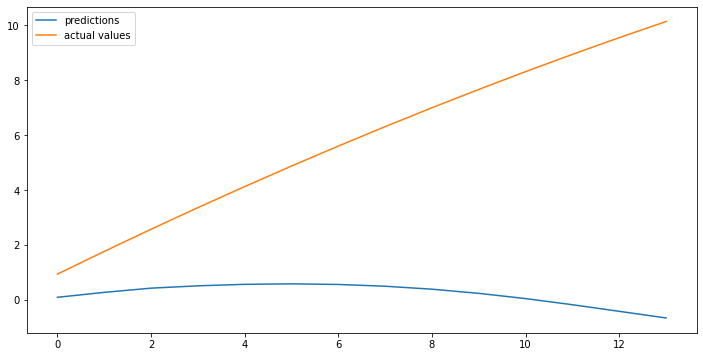

In [17]:
#multi-step
replica = 0

plt.clf()
plt.figure(figsize=(12,6))

df_results_0 = pd.DataFrame(scaler.transform(globals()['batch_'+str(batches_test[0])].loc[3:16].reset_index(drop=True).values), columns = ['c0', 'c1', 'c2', 'val'])
df_results_0['pred'] = final_predictions_replicas[replica][0]
df_results_0 = df_results_0[['val', 'pred']]

plt.plot(df_results_0['pred'], label = 'predictions')
plt.plot(df_results_0['val'], label = 'actual values')

plt.legend()

<Figure size 432x288 with 0 Axes>

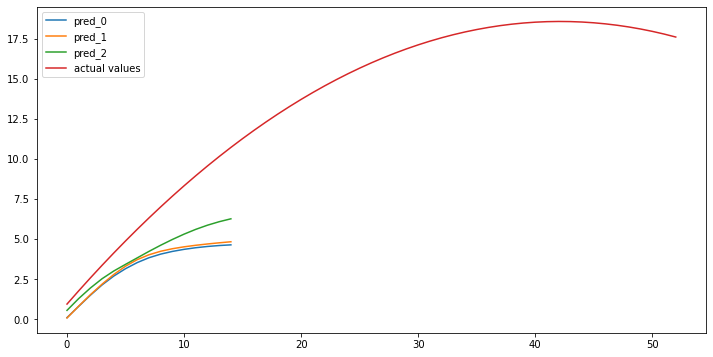

In [18]:
# one-step -- batches teste:

batch_graf = batches_test[0]

plt.clf()
plt.figure(figsize=(12,6))

df_results_0_val = pd.DataFrame(scaler.transform(globals()['batch_'+ str(batch_graf)].loc[3:].reset_index(drop=True).values), columns = ['c0', 'c1', 'c2', 'val'])['val']
j=0
for i in model_replicas:
    plt.plot(i.predict(X_teste), label = ('pred_'+str(j)))
    j+=1

plt.plot(df_results_0_val, label = 'actual values')

plt.legend()

<Figure size 432x288 with 0 Axes>

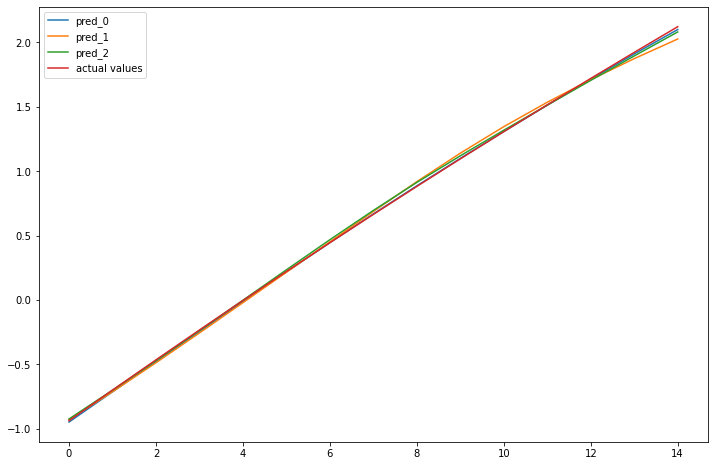

In [23]:
# one-step -- batches treino:

idx = 2
batch_graf = batches_train[idx]

plt.clf()
plt.figure(figsize=(12,8))

df_results_0_val = pd.DataFrame(scaler.transform(globals()['batch_'+ str(batch_graf)].loc[3:].reset_index(drop=True).values), columns = ['c0', 'c1', 'c2', 'val'])['val']
j=0
for i in model_replicas:
    plt.plot( i.predict(X_treino[ (0+(idx*15)):(15+(idx*15)) ]), label = ('pred_'+str(j)))
    j+=1

plt.plot(df_results_0_val, label = 'actual values')

plt.legend()

<Figure size 432x288 with 0 Axes>

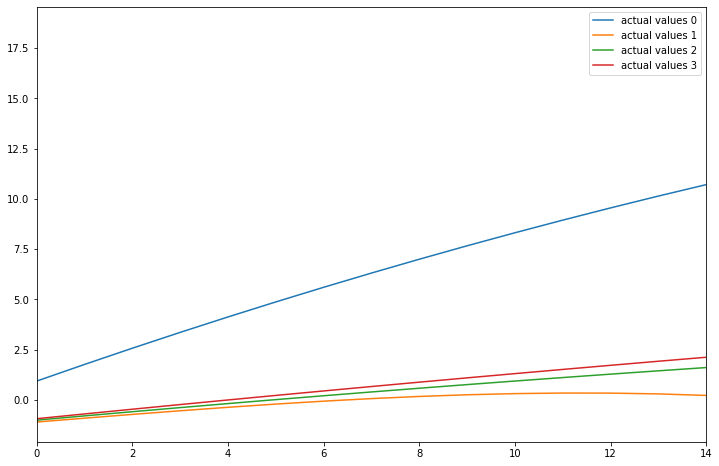

In [20]:
plt.clf()
plt.figure(figsize=(12,8))
plt.axis(xmax = 14)
for batch in batches_utilizados:
    df_results_0_val = pd.DataFrame(scaler.transform(globals()['batch_'+ str(batch)].loc[3:].reset_index(drop=True).values), columns = ['c0', 'c1', 'c2', 'val'])['val']
    plt.plot(df_results_0_val, label = 'actual values '+str(batch))

plt.legend()